In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10 

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 490 files belonging to 5 classes.


In [4]:
# Get the number of classes
class_names = dataset.class_names
n_classes = len(class_names)  

print("Class Names:", class_names)
print("Number of Classes:", n_classes)

Class Names: ['healthy', 'leaf curl', 'leaf spot', 'whitefly', 'yellowish']
Number of Classes: 5


In [5]:
len(dataset)

16

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 4 3 3 4 4 4 3 2 0 0 4 4 0 3 4 1 0 4 4 3 4 2 0 4 4 4 0 0 0 2 2]


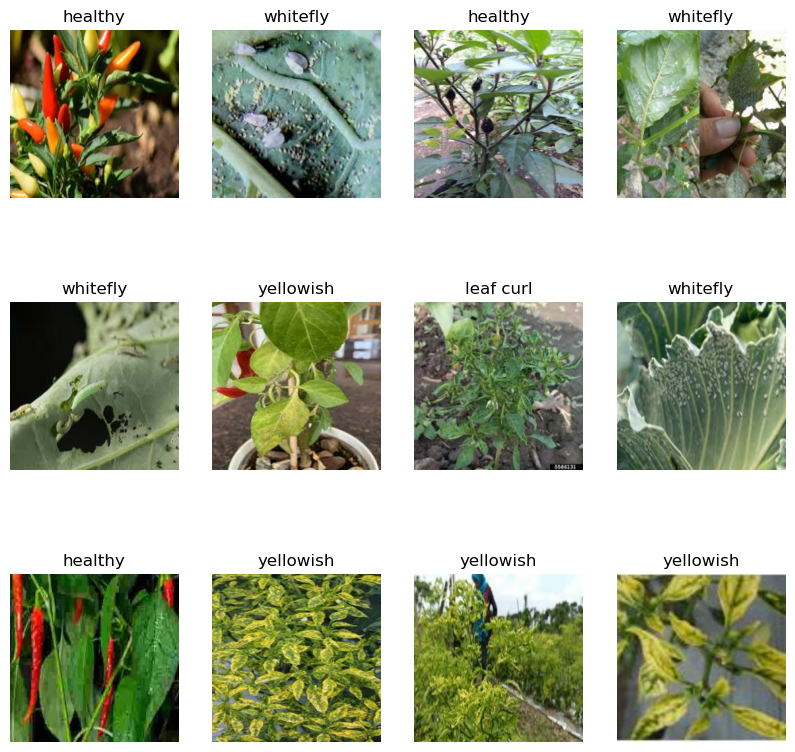

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
#*80% ==>training,
#0% ==>10% validation, 10% test

In [9]:
train_size=0.8
len(dataset)*train_size

12.8

In [10]:
train_ds=dataset.take(54)
len(train_ds)

16

In [11]:
test_ds=dataset.skip(54)
len(test_ds)

0

In [12]:
val_size=0.1
len(dataset)*val_size

1.6

In [13]:
val_ds=test_ds.take(6)
len(val_ds)

0

In [14]:
test_ds=test_ds.skip(6)
len(test_ds)

0

In [15]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

print("Training samples:", len(train_ds))
print("Validation samples:", len(val_ds))
print("Test samples:", len(test_ds))

Training samples: 12
Validation samples: 1
Test samples: 3


In [16]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [17]:
len(train_ds)

12

In [18]:
len(val_ds)

1

In [19]:
len(test_ds)

3

In [20]:
# Optimize dataset loading
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])



In [22]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [23]:
# Model architecture
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    layers.Input(shape=input_shape), 
    resize_and_rescale,
    data_augmentation,

    # 1st Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    # 2nd Convolutional Block
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # 3rd Convolutional Block
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # 4th Convolutional Block
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'), 
])

C:\Users\Sulochana\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,211,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,600,069 (13.73 MB)

 Trainable params: 3,600,069 (13.73 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.1747 - loss: 1.7671 - val_accuracy: 0.1875 - val_loss: 1.6271
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.2471 - loss: 1.6002 - val_accuracy: 0.3125 - val_loss: 1.4550
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.2909 - loss: 1.5252 - val_accuracy: 0.2812 - val_loss: 1.4167
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.3234 - loss: 1.4941 - val_accuracy: 0.3750 - val_loss: 1.3878
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.3469 - loss: 1.4223 - val_accuracy: 0.1562 - val_loss: 1.4366
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 967ms/step - accuracy: 0.3129 - loss: 1.4004 - val_accuracy: 0.4375 - val_loss: 1.2194
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4174 - loss: 1.3094 - val_accuracy: 0.5625 - val_loss: 1.1133
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4377 - loss: 1.2332 - val_accuracy: 0.4375 - val_lo

In [28]:
scores = model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.4479 - loss: 1.3955


In [29]:
scores

[1.3141882419586182, 0.4583333432674408]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 12}

In [32]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [33]:
history.history['accuracy']

[0.1875,
 0.234375,
 0.2916666567325592,
 0.3151041567325592,
 0.3229166567325592,
 0.3671875,
 0.4114583432674408,
 0.4375,
 0.4739583432674408,
 0.4973958432674408]

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

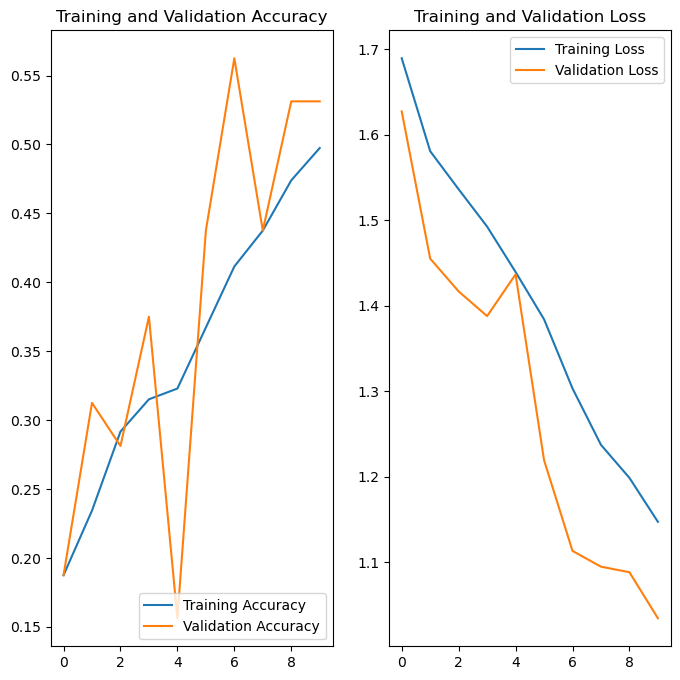

In [35]:
plt.figure(figsize =(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS),acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: leaf curl
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
predicted label: yellowish


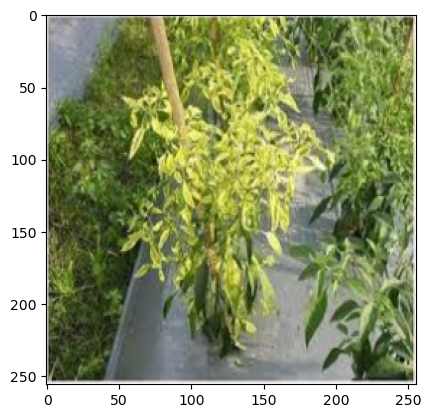

In [36]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


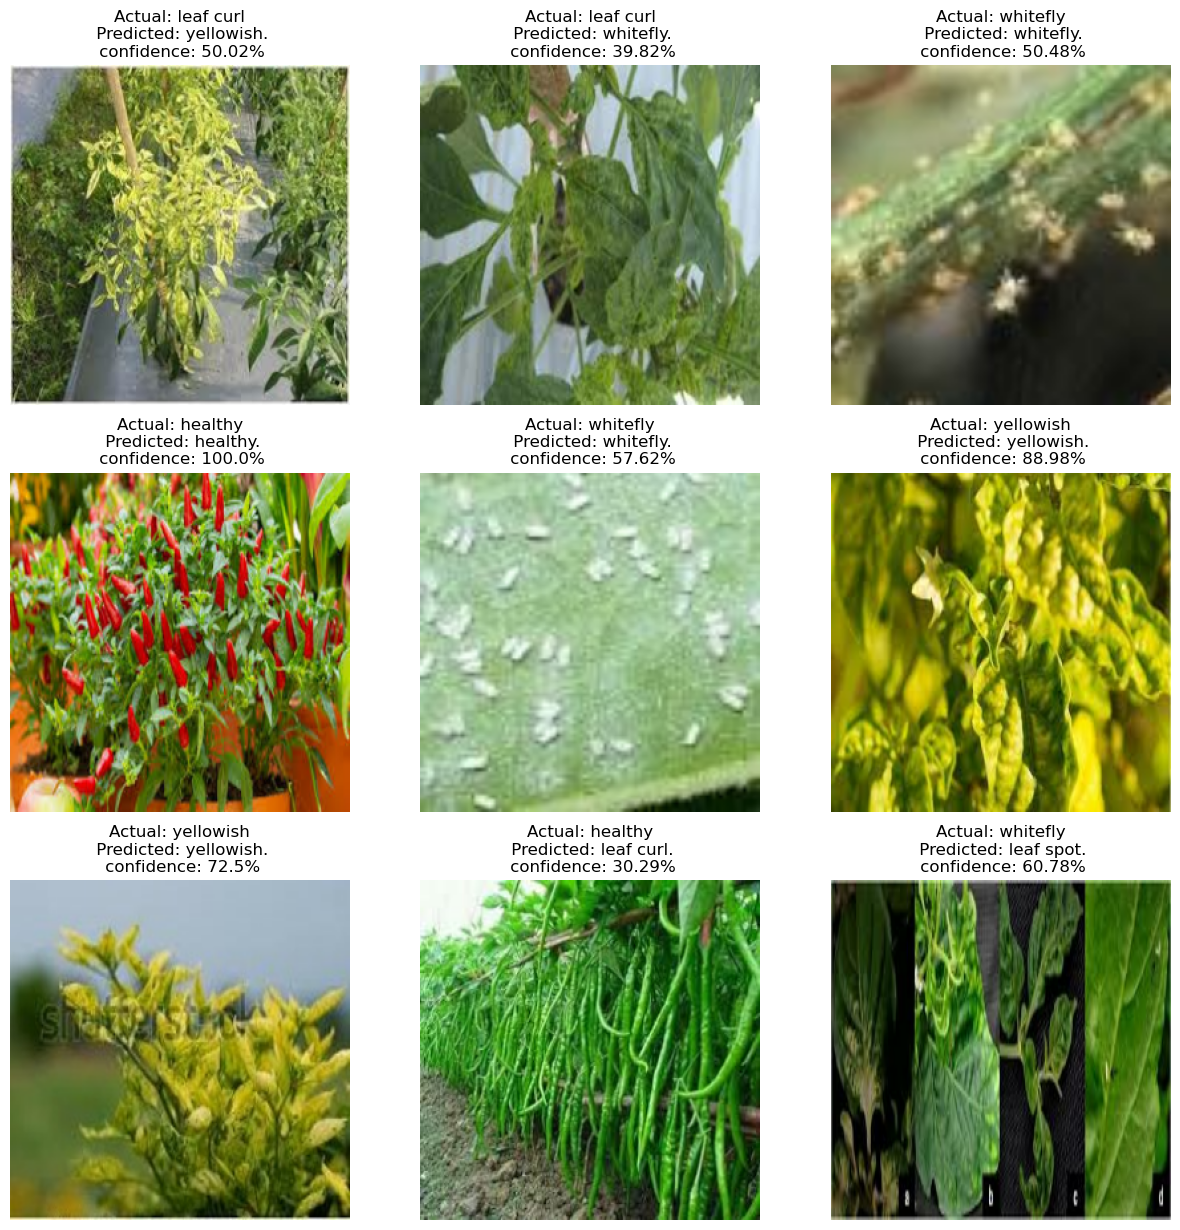

In [38]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}.\n confidence: {confidence}%")


        plt.axis("off")

In [42]:
import os

folder_path = "model"

if os.path.exists(folder_path) and os.path.isdir(folder_path):
    print(os.listdir(folder_path))
else:
    print(f"Error: Directory '{folder_path}' does not exist!")

[]


In [44]:
# Define the variable bellpepper_dep
chilli_dep = "v1.0"  # You can set this to the appropriate version string

# Now you can use it to save the model
model_version = chilli_dep
model.save(f"model/{model_version}.keras")  # Save the model with the version in the filename

In [48]:
model_path = "chilli_model.h5"

# Check if the model file exists
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print("✅ Model loaded and compiled successfully!")
else:
    print(f"❌ Error: Model file '{model_path}' not found! Check the file path.")


❌ Error: Model file 'chilli_model.h5' not found! Check the file path.
